# Imports & Data Loading

In [ ]:
!unzip -qq colabData.zip
# Includes the data and the utilitis folder
# Folder Hierarchy should be as following:
# /Coursework
#    /Coursework_Registration.ipynb
#    /data
#       /atlas
#       /test
#       /tune
#    /demonsReg.py
#    /utilsCoursework.py

In [ ]:
import os
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.io
from utilsCoursework import dispImage,resampImageWithDefField,calcMSD,calcLMSD,dispDefField
from demonsReg import demonsReg

# Set the paths to datasets
pathToAtlas = 'data/atlas'
pathToTune  = 'data/tune'
pathToTest  = 'data/test'

# Turns off some Runtime warnings coming from demonsReg.py file when doing some
# divisions
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

# 1.1 Inspect the data

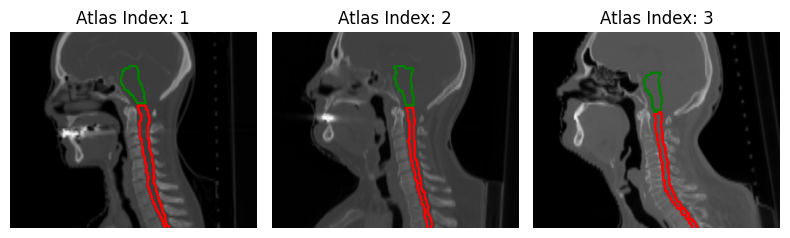

-----------------------------------------------------------------------


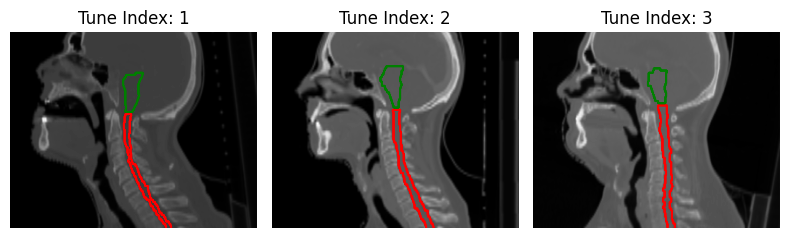

-----------------------------------------------------------------------


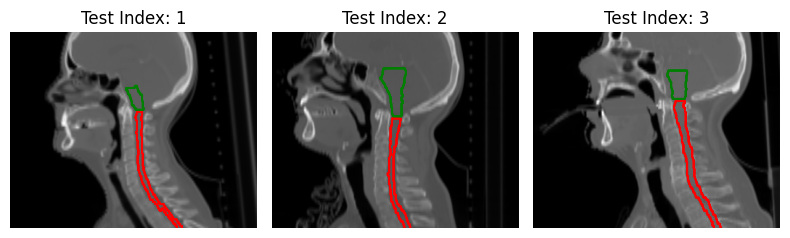

In [ ]:
# Use SKimage to load the images and return them as an numpy array
def getImage(path):
    image = skimage.io.imread(path)
    image = np.flipud(np.double(image)).T
    return image

# Takes an index for which image to print at the path given
def visualisation(index, path, ax=None):
    # As we have a pattern in the file names, the path will be hard coded
    image = os.path.join(path, ('{}_{}.png'.format(os.path.basename(path), index)))
    brainImage = os.path.join(path, ('{}_{}_BRAIN_STEM.png'.format(os.path.basename(path), index)))
    spinalImage = os.path.join(path, ('{}_{}_SPINAL_CORD.png'.format(os.path.basename(path), index)))

    # use the utility function to print the image and also add the brain stem
    # and spinal cord outlines
    dispImage(getImage(image), ax=ax)
    plt.contour(getImage(spinalImage).T, colors='red', linewidths=1)
    plt.contour(getImage(brainImage).T,colors='green', linewidths=1)


fig = plt.figure(figsize=(8,8))
for i in range(1,4):
    ax = fig.add_subplot(2,3, i)
    visualisation(i, pathToAtlas, ax=ax)
    ax.set_title('Atlas Index: {}'.format(i))
    plt.axis('off')
    plt.tight_layout()
# plt.suptitle('Atlas Images')
plt.show()
plt.close()

print('-----------------------------------------------------------------------')

fig = plt.figure(figsize=(8,8))
for i in range(1,4):
    ax = fig.add_subplot(2,3, i)
    visualisation(i, pathToTune, ax=ax)
    ax.set_title('Tune Index: {}'.format(i))
    plt.axis('off')
    plt.tight_layout()
# plt.suptitle('Tune Images')
plt.show()

print('-----------------------------------------------------------------------')

fig = plt.figure(figsize=(8,8))
for i in range(1,4):
    ax = fig.add_subplot(2,3, i)
    visualisation(i, pathToTest, ax=ax)
    ax.set_title('Test Index: {}'.format(i))
    plt.axis('off')
    plt.tight_layout()
# plt.suptitle('Tune Images')
plt.show()

# 1.2 Tune the registration parameters


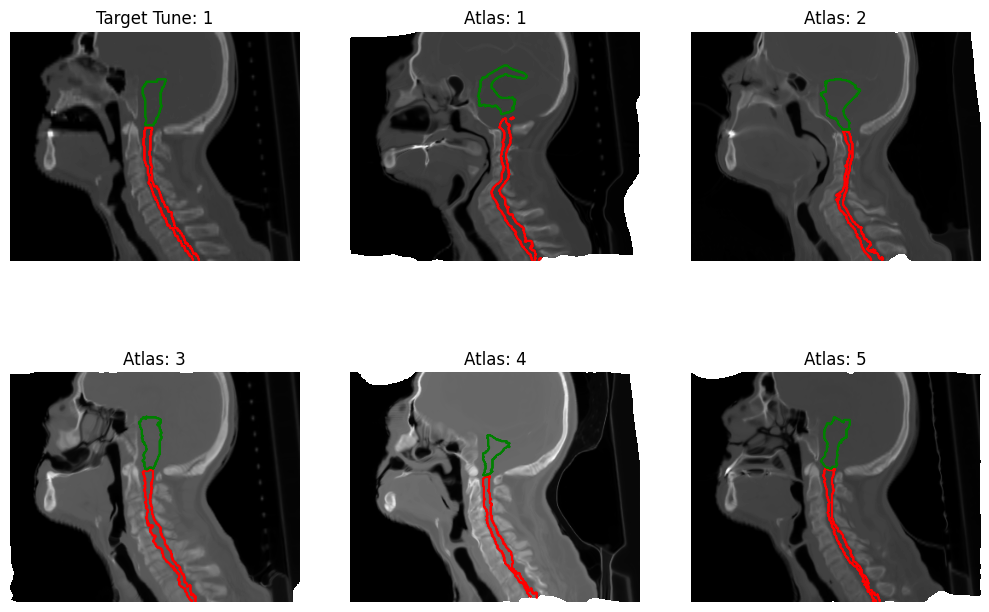

-------------------------------------------------------------------


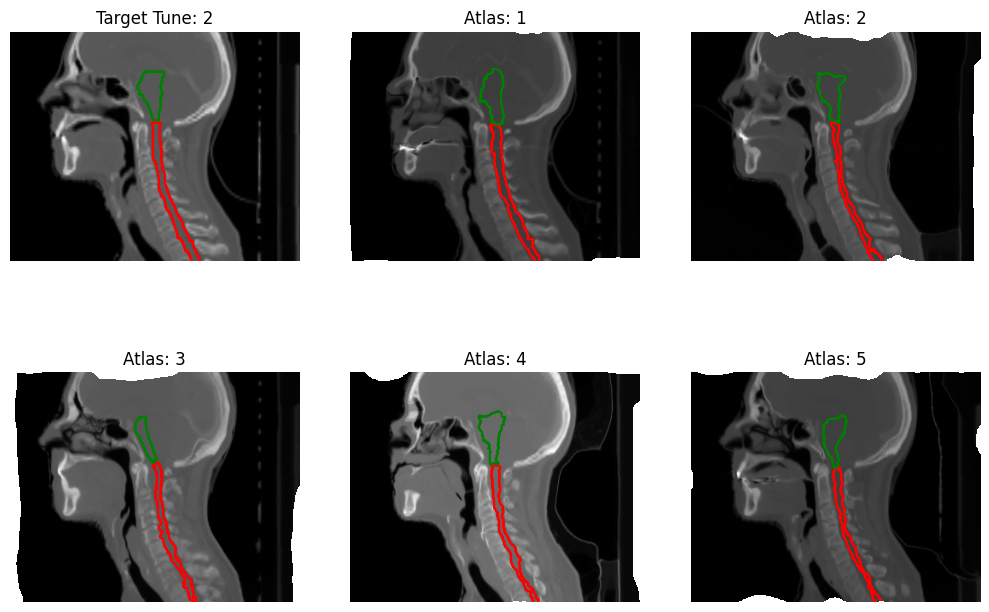

-------------------------------------------------------------------


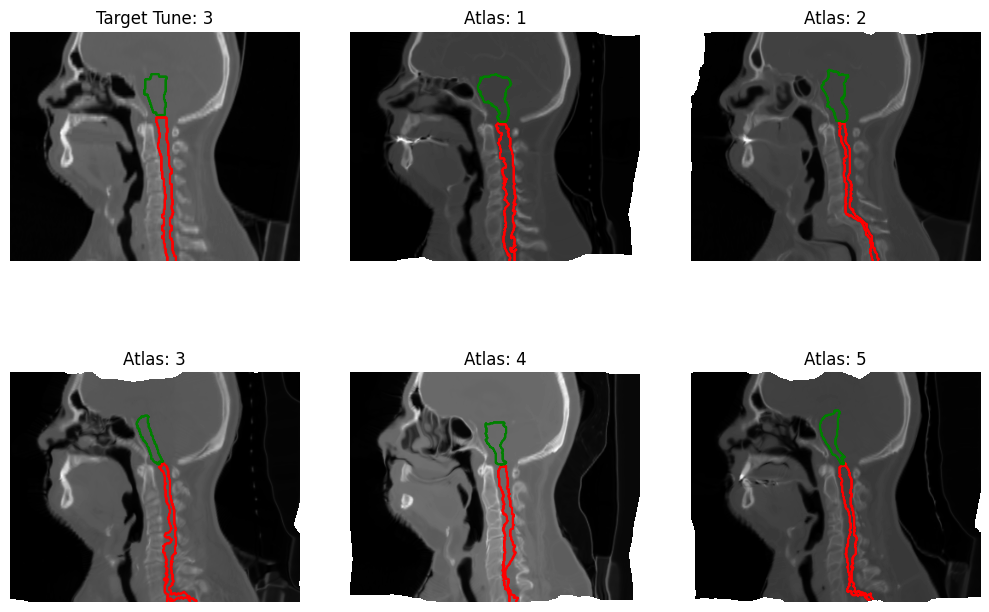

-------------------------------------------------------------------


In [ ]:
# Loops over the 3 tunning images
for i in range(1,4):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(2,3,1)
    visualisation(i, pathToTune, ax=ax)
    ax.set_title('Target Tune: {}'.format(i))
    ax.axis('off')
    tuneImage = getImage(pathToTune + '/tune_{}.png' .format(i))
    
    # Loop over the 5 atlas images and performs the demons registration over the
    # tuning image set above
    for j in range(1,6):
        
        # Loads the current atlas image and start the demons registration
        # The atlas is the source while the tuning is the target
        # In the demonsReg I included a new paramenter "showProgress" which will
        # hide all the prints from the algorithm. Remove it if you run the code.
        atlasImage = getImage(pathToAtlas + '/atlas_{}.png'.format(j))
        warpedImage, defField = demonsReg(atlasImage, tuneImage, 
                                          disp_freq = 0,
                                          showProgress = False)

        # Gets the Brain Stem and Spinal Cord images which are warped using the
        # Deformation field returned by the demons registration functio
        brainImage = getImage(pathToAtlas + '/atlas_{}_BRAIN_STEM.png'.format(j))
        spinalImage = getImage(pathToAtlas + '/atlas_{}_SPINAL_CORD.png'.format(j))
        defBrainImage = resampImageWithDefField(brainImage, defField, interp_method='nearest')
        defSpinalImage = resampImageWithDefField(spinalImage, defField, interp_method='nearest')

        # Converting to Binary 0 and 1
        defBrainImageBIN = np.where(defBrainImage >= 0.5, 1, 0)
        defSpinalImageBIN = np.where(defSpinalImage >= 0.5, 1, 0)

        # Adds the deformed image returned by the demons registration function
        # to the plot and overlays the deformed brain and spinal images.
        ax = fig.add_subplot(2,3,(j+1))
        dispImage(warpedImage, ax=ax)
        ax.set_title('Atlas: {}'.format(j))
        ax.axis('off')
        plt.contour(defSpinalImage.T, colors='red', linewidths=1)
        plt.contour(defBrainImage.T, colors='green',linewidths=1)

    plt.axis('off')
    plt.show()
    print("-------------------------------------------------------------------")

    # drivePath = '/content/drive/MyDrive/Colab Notebooks/MPHY0025: Information Processing in Medical Imaging/CW/plots/'
    # nameFig = drivePath + 'Reg_Tune_{}_nLevs_{}_Compos_{}_Elast_{}_Fluid_{}.png'.format(i,numLevs,useComposition,sigmaElastic,sigmaFluid)
    # fig.savefig(nameFig, dpi=fig.dpi)

## Finding best parameters for demonsReg

In [ ]:
# demonsReg Parameters
for ii in range(1,7):
  numLevs = ii

  for jj in range(0,2):
    useComposition = jj # 1/0 only | True/False

    rangeElastic = [1,1.2,1.4,1.6]
    for kk in rangeElastic:
      sigmaElastic = kk

      rangeFluid = [1,1.2,1.4,1.6]
      for ll in rangeFluid:
        sigmaFluid = ll

        print('numLev: {}, useComposition: {}, Elastic: {}, Fluid: {}'.format(numLevs,useComposition,sigmaElastic,sigmaFluid))

        # Loops over the 3 tunning images
        for i in range(1,2):
            fig = plt.figure(figsize=(10,10))
            ax = fig.add_subplot(2,3,1)
            visualisation(i, pathToTune, ax=ax)
            ax.set_title('Target Tune: {}'.format(i))
            ax.axis('off')
            tuneImage = getImage(pathToTune + '/tune_{}.png' .format(i))
            
            # Loop over the 5 atlas images and performs the demons registration over the
            # tuning image set above
            for j in range(1,6):
                
                # Loads the current atlas image and start the demons registration
                # The atlas is the source while the tuning is the target
                # In the demonsReg I included a new paramenter "showProgress" which will
                # hide all the prints from the algorithm. Remove it if you run the code.
                atlasImage = getImage(pathToAtlas + '/atlas_{}.png'.format(j))
                warpedImage, defField = demonsReg(atlasImage, tuneImage, 
                                                  disp_freq = 0, 
                                                  max_it = 500, 
                                                  num_lev = numLevs,
                                                  use_composition = useComposition,
                                                  sigma_elastic = sigmaElastic,
                                                  sigma_fluid = sigmaFluid,
                                                  showProgress = False)

                # Gets the Brain Stem and Spinal Cord images which are warped using the
                # Deformation field returned by the demons registration functio
                brainImage = getImage(pathToAtlas + '/atlas_{}_BRAIN_STEM.png'.format(j))
                spinalImage = getImage(pathToAtlas + '/atlas_{}_SPINAL_CORD.png'.format(j))
                defBrainImage = resampImageWithDefField(brainImage, defField, interp_method='nearest')
                defSpinalImage = resampImageWithDefField(spinalImage, defField, interp_method='nearest')

                # Converting to Binary 0 and 1
                defBrainImageBIN = np.where(defBrainImage >= 0.5, 1, 0)
                defSpinalImageBIN = np.where(defSpinalImage >= 0.5, 1, 0)

                # Adds the deformed image returned by the demons registration function
                # to the plot and overlays the deformed brain and spinal images.
                ax = fig.add_subplot(2,3,(j+1))
                dispImage(warpedImage, ax=ax)
                ax.set_title('Atlas: {}'.format(j))
                ax.axis('off')
                plt.contour(defSpinalImageBIN.T, colors='red', linewidths=1)
                plt.contour(defBrainImageBIN.T, colors='green',linewidths=1)
                
            plt.axis('off')
            # plt.show()
            print("-------------------------------------------------------------------")

            drivePath = '/content/drive/MyDrive/Colab Notebooks/MPHY0025: Information Processing in Medical Imaging/CW/plots/'
            nameFig = drivePath + 'Reg_Tune_{}_nLevs_{}_Compos_{}_Elast_{}_Fluid_{}.png'.format(i,numLevs,useComposition,sigmaElastic,sigmaFluid)
            fig.savefig(nameFig, dpi=fig.dpi)
            plt.close()

# 1.3 Multi-atlas segmentation

In [ ]:
# demonsReg Parameters based on 192 tests
numLevs = 5
useComposition = 0 # 1/0 only | True/False
sigmaElastic = 1.4
sigmaFluid = 1.2

# Function takes a tagert image and returns the binary image of the estimated
# brain stem and spinal cord.
def multiAtlasSeg(targetImage):
    
    # 3D variables to store the data from each Atlas image run
    # These will be used after the loop ends to estimate the multi atlas seg.
    lmsd = np.zeros((5,340, 270))
    reg_weight = np.zeros((5,340, 270))
    reg_weight_norm = np.zeros((5,340, 270))
    binBrainImg = np.zeros((5,340, 270))
    binSpinalImg = np.zeros((5,340, 270))

    # Looping through 5 Atlas Images
    for i in range(1,6):
        print('   - Running Atlas: ',i)

        # Loads the current atlas image and start the demons registration
        # The atlas is the source while the tuning is the target
        # In the demonsReg I included a new paramenter "showProgress" which will
        # hide all the prints from the algorithm. Remove it if you run the code.
        atlasImage = getImage(pathToAtlas + '/atlas_{}.png'.format(i))
        warpedImage, defField = demonsReg(atlasImage, targetImage, 
                                          disp_freq = 0, 
                                          max_it = 500, 
                                          num_lev = numLevs,
                                          use_composition = useComposition,
                                          sigma_elastic = sigmaElastic,
                                          sigma_fluid = sigmaFluid,
                                          showProgress = False)
        
        # Getting the spinal cord and brain stem images of the current atlas image
        # After we resample these using the deformation field from demonsReg
        brainImage = getImage(pathToAtlas + '/atlas_{}_BRAIN_STEM.png'.format(i))
        spinalImage = getImage(pathToAtlas + '/atlas_{}_SPINAL_CORD.png'.format(i))
        resampleBrain = resampImageWithDefField(brainImage, defField, interp_method='nearest')
        resampleSpinal = resampImageWithDefField(spinalImage, defField, interp_method='nearest')

        # Convert to binary and store the images into the 3D variable
        binBrainImg[i-1] = np.where(resampleBrain >= 0.5, 1, 0)
        binSpinalImg[i-1] = np.where(resampleSpinal >= 0.5, 1, 0)

        # Fixes a problem where the warped image ends up having too much empty 
        # space (NaN / None values) which will cause problems in the LMSD calculation
        # therefore we fill all the empty values with 0s
        # More details in the report
        warpedImage = np.nan_to_num(warpedImage)

        # Calculate LMSD and store them in 3D variable
        lmsd[i-1] = calcLMSD(targetImage, warpedImage, 20)
    
    # Calculate the registration weight for each atlas' LMSD calculated in the loop
    for i in range(lmsd.shape[0]):
        reg_weight[i] = 1/(1+lmsd[i])

    # Normalise the reistration weight for each atlas image based on your instructions
    # I believe this could be done directly though the entire array but due to some
    # previous problem i followed your exact instructions.
    for i in range(reg_weight.shape[0]):
        reg_weight_norm[i] = (reg_weight[i] / np.sum(reg_weight))

    # Calculate the Multi-Atlas segmentations using the given formula
    # Numbers are exponentially low, probably fue to my nan_to_num fix explained
    # in the report. Due to this i had to increase the numbers up.
    MASprob_brain  = (np.sum((reg_weight_norm*binBrainImg),axis=0))*(10**7)
    MASprob_spinal = (np.sum((reg_weight_norm*binSpinalImg),axis=0))*(10**9)

    # Convert the MAPs to binary
    binaryBrain = np.where(MASprob_brain >= 0.5, 1, 0)
    binarySpinal = np.where(MASprob_spinal >= 0.5, 1, 0)

    return binaryBrain, binarySpinal



## Tuning Patients

Running Tune:  1
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5
Running Tune:  2
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5
Running Tune:  3
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5


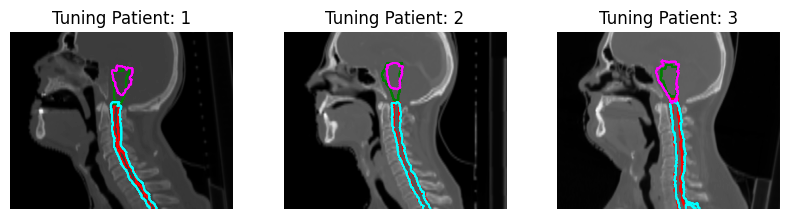

In [ ]:
fig = plt.figure(figsize=(8,8))

# Loopiong through the Tuning patients to test the Multi Atlas Segmentation function
for i in range(1,4):
  print('Running Tune: ',i)

  # gets the target image and its brain stem and spinel cord segments
  target = getImage(pathToTune + '/tune_{}.png' .format(i))
  brainImage = getImage(pathToTune + '/tune_{}_BRAIN_STEM.png'.format(i))
  spinalImage = getImage(pathToTune + '/tune_{}_SPINAL_CORD.png'.format(i))

  # get the binary MAPs
  binaryBrain, binarySpinal = multiAtlasSeg(target)

  # Plot the results for each image from this loop
  ax = fig.add_subplot(2,3,i)
  dispImage(target)
  ax.set_title('Tuning Patient: {}'.format(i))
  ax.axis('off')

  # Apply the contours of the brain stem and spinal cord
  plt.contour(spinalImage.T, colors='red', linewidths=1)
  plt.contour(brainImage.T,colors='green', linewidths=1)
  plt.contour(binarySpinal.T, colors='cyan', linewidths=1)
  plt.contour(binaryBrain.T, colors='magenta', linewidths=1)

plt.show()
plt.close()

## Testing Patients

Running Testing:  1
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5
Running Testing:  2
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5
Running Testing:  3
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5
Running Testing:  4
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5
Running Testing:  5
   - Running Atlas:  1
   - Running Atlas:  2
   - Running Atlas:  3
   - Running Atlas:  4
   - Running Atlas:  5


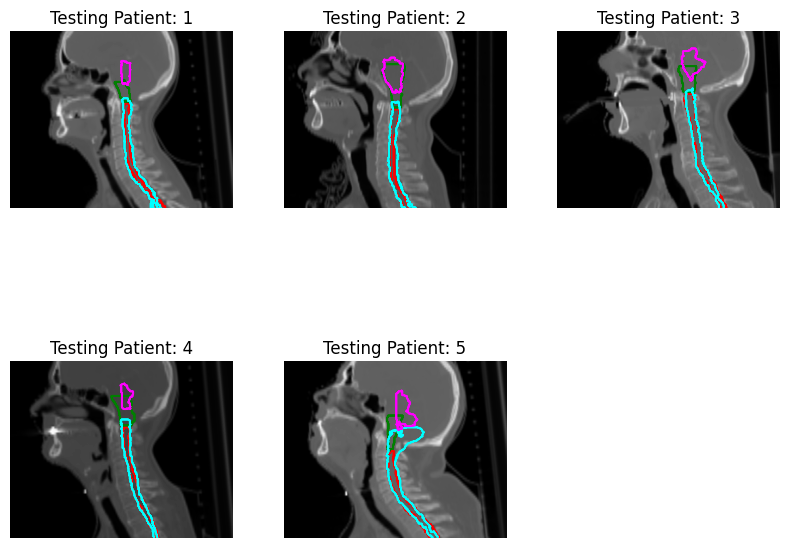

In [ ]:
fig = plt.figure(figsize=(8,8))

# Loopiong through the Testing patients to test the Multi Atlas Segmentation function
for i in range(1,6):
  print('Running Testing: ',i)

  # gets the target image and its brain stem and spinel cord segments
  target = getImage(pathToTest + '/test_{}.png' .format(i))
  brainImage = getImage(pathToTest + '/test_{}_BRAIN_STEM.png'.format(i))
  spinalImage = getImage(pathToTest + '/test_{}_SPINAL_CORD.png'.format(i))

  # get the binary MAPs
  binaryBrain, binarySpinal = multiAtlasSeg(target)

  # Plot the results for each image from this loop
  ax = fig.add_subplot(2,3,i)
  dispImage(target)
  ax.set_title('Testing Patient: {}'.format(i))
  ax.axis('off')

  # Apply the contours of the brain stem and spinal cord
  plt.contour(spinalImage.T, colors='red', linewidths=1)
  plt.contour(brainImage.T,colors='green', linewidths=1)
  plt.contour(binarySpinal.T, colors='cyan', linewidths=1)
  plt.contour(binaryBrain.T, colors='magenta', linewidths=1)

plt.show()
plt.close()